In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
import gseapy as gp
import celltypist
from celltypist import models
import scrublet as scr
from scipy.io import mmread

# Inline plotting
%matplotlib inline

/home/mahim/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mahim/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mahim/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The '

## Read in data and preprocessing

In [ ]:
adata = sc.read_10x_mtx(
    './P25/',  
    var_names='gene_symbols',                
    cache=True)

In [ ]:
adata.var_names_make_unique() 
adata

In [ ]:
#adata.raw = adata
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e4)
sc.pp.log1p(adata)

In [ ]:
adata.obs

## Celltype annotation with celltypist

In [ ]:
# Create a CellTypist object and perform cell type annotation
models.download_models(model = ['Immune_All_Low.pkl', 'Immune_All_High.pkl'])

#Select the model from the above list. If the `model` argument is not provided, will default to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Immune_All_Low.pkl')
#The model summary information.
model
#Examine cell types contained in the model.
model.cell_types
#Examine genes/features contained in the model.
model.features

# Annotate cell types
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl')

# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata()

In [ ]:
adata.obs

In [ ]:
# Compute neighborhood graph
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['predicted_labels'], legend_loc = 'right margin')

## Subset to only CD8 T cells

In [ ]:
# Perform Leiden clustering
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'], legend_loc='on data')  # Plot UMAP with Leiden clustering labels


In [ ]:
#CD8 cells
sc.pl.umap(adata, color=['CD8A', 'CD8B', 'TRBC2', 'CD3D', 'CD3G', 'CD3E', 'IL7R', 'GZMK', 'LTB', 'LEF1'])

In [ ]:
markers = {'CD8+ T Cells' : ['CD8A', 'CD8B', 'TRBC2', 'CD3D', 'CD3G', 'CD3E', 'IL7R', 'GZMK', 'LTB', 'LEF1'], 'B Cells' : ['PXK', 'CD19', 'MS4A1', 'CD74', 'CD79A', 'IGHD'], 'NK Cells' : ['KLRD1', 'NKG7', 'GNLY', 'STYK1', 'GZMA', 'GZMB'], 'DC' : ['FCER1A', 'CST3', 'ZBTB46', 'ITGAX', 'CX3CR1', 'ITGAM'], 'Macrophages' : ['ID1', 'FAR2', 'IFITM1', 'NFIL3', 'NPL', 'OTUB2'], 'Monocytes' : ['LYZ', 'CFP', 'APOBEC3A', 'CD7', 'TET2'], 'NKT' : ['IL2RB', 'NCAM1', 'CD44', 'IL12RB2', 'CXCR4'], 'Plasma' : ['MZB1', 'SSR4', 'IGHG1']}
sc.pl.dotplot(adata, markers, groupby = 'leiden', dendrogram = True, show = False)

plt.savefig('./Pancreas_25_before_filtering_marker_genes_CD8+_T_cells.pdf', dpi = 300, bbox_inches = 'tight')

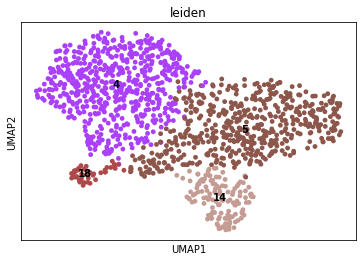

In [12]:
leiden_clusters_to_keep = ['5', '4', '14', '18']
adata_cd8 = adata[adata.obs['leiden'].isin(leiden_clusters_to_keep)]
adata_cd8

# 5. Visualize the results
sc.tl.umap(adata_cd8) 
sc.pl.umap(adata_cd8, color=['leiden'], legend_loc='on data')  

In [13]:
adata_cd8

AnnData object with n_obs × n_vars = 1301 × 36601
    obs: 'n_counts', 'predicted_labels', 'conf_score', 'leiden'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p', 'neighbors', 'umap', 'predicted_labels_colors', 'leiden', 'leiden_colors', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

categories: 4, 5, 14, etc.
var_group_labels: CD8+ T Cells, B Cells, NK Cells, etc.


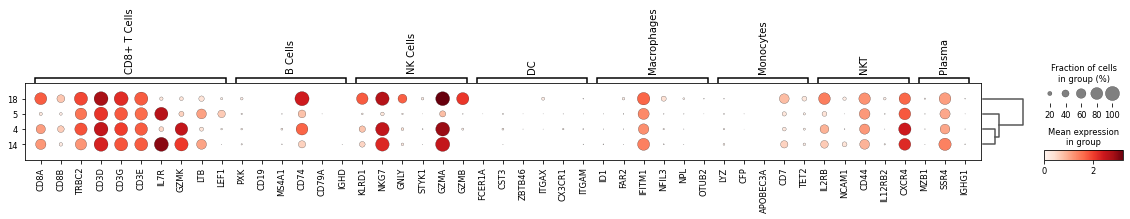

In [14]:
# First, recompute the dendrogram
sc.tl.dendrogram(adata_cd8, groupby='leiden')

# Then, plot the dot plot with the dendrogram
sc.pl.dotplot(adata_cd8, markers, groupby='leiden', dendrogram=True, show=False)

plt.savefig('./Pancreas_24_marker_genes_CD8+_T_cells.pdf', dpi=300, bbox_inches='tight')

## Module score

In [15]:
single_cell = pd.read_csv('./DEG_high_vs_low_salt_Mahima', sep = '\t')
single_cell.sort_values('avg_log2FC', inplace = True, ascending = False) 
single_cell.head()

,Unnamed: 0,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
7,MT1G,0.000000e+00,2.041876,0.612,0.274,0.000000e+00
8,CCDC200,0.000000e+00,1.591479,0.684,0.299,0.000000e+00
13,MT1X,3.287614e-291,1.511235,0.798,0.681,1.203300e-286
6,MT1E,0.000000e+00,1.489193,0.840,0.680,0.000000e+00
0,ATF3,0.000000e+00,1.320619,0.888,0.651,0.000000e+00


In [16]:
bulk = pd.read_csv('./bulk_CD8_salt.csv')
bulk.sort_values('LFC_cd8_highsalt_vs_cd8_lowsalt', inplace = True, ascending = False) 
bulk.head()

,geneid,genename,description,meanExpression,LFC_cd8_highsalt_vs_cd8_lowsalt,DE_cd8_highsalt_vs_cd8_lowsalt,FDR_cd8_highsalt_vs_cd8_lowsalt,SE_cd8_highsalt_vs_cd8_lowsalt
19654,ENSG00000203812,HIST2H2AA3,histone cluster 2 H2A family member a3 [Source...,59.380140,9.044432,upregulated,4.538278e-05,1.932420
11308,ENSG00000164303,ENPP6,ectonucleotide pyrophosphatase/phosphodiestera...,55.118948,7.882688,upregulated,1.443054e-11,1.073436
4011,ENSG00000112164,GLP1R,glucagon like peptide 1 receptor [Source:HGNC ...,17.495594,7.358995,upregulated,7.692128e-06,1.450413
57902,ENSG00000285000,AC008581.2,"novel protein, AGGF1-ZBED3-AS1 readthrough",23.406867,7.012590,unchanged,1.938578e-01,3.910456
2868,ENSG00000104055,TGM5,transglutaminase 5 [Source:HGNC Symbol;Acc:HGN...,45.181923,6.914169,upregulated,1.071693e-07,1.169303


In [17]:
bulk_upregulated_sig = list(bulk.query('DE_cd8_highsalt_vs_cd8_lowsalt == "upregulated" and (FDR_cd8_highsalt_vs_cd8_lowsalt < 0.001)')['genename'])
bulk_downregulated_sig = list(bulk.query('DE_cd8_highsalt_vs_cd8_lowsalt == "downregulated" and (FDR_cd8_highsalt_vs_cd8_lowsalt < 0.001)')['genename'])

single_cell_upregulated_sig = list(single_cell.query('(avg_log2FC > 0) and (p_val_adj < 0.001)')['Unnamed: 0'])
single_cell_downregulated_sig = list(single_cell.query('(avg_log2FC < 0) and (p_val_adj < 0.001)')['Unnamed: 0'])


gene_set_significant = {'bulk_upregulated'         : bulk_upregulated_sig, 
                       'bulk_downregulated'        : bulk_downregulated_sig,
                       'single_cell_upregulated'   : single_cell_upregulated_sig,
                       'single_cell_downregulated' : single_cell_downregulated_sig
                       }

bulk_salt_group
cd8+_low_salt     1113
cd8+_high_salt     188
Name: count, dtype: int64


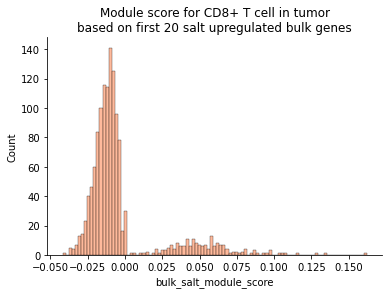

In [21]:
cutof = 20
sc.tl.score_genes(adata_cd8, gene_list=gene_set_significant['bulk_upregulated'][:cutof], score_name='bulk_salt_module_score')

# Set the threshold for low and high salt
threshold = 0

# Create a new column indicating high or low salt based on the threshold
adata_cd8.obs['bulk_salt_group'] = pd.cut(adata_cd8.obs['bulk_salt_module_score'], bins=[-float('inf'), threshold, float('inf')],
                                 labels=['cd8+_low_salt', 'cd8+_high_salt'], include_lowest=True)

print(adata_cd8.obs['bulk_salt_group'].value_counts())
sns.histplot(adata_cd8.obs['bulk_salt_module_score'])
plt.title(f'Module score for CD8+ T cell in tumor\nbased on first {cutof} salt upregulated bulk genes')
sns.despine()

plt.savefig(f'./MA_Pancreas_24_module score for CD8+ T cell in tumor\nbased on first {cutof} salt upregulated bulk genes.pdf', dpi=300, bbox_inches='tight')

In [22]:
from importlib import reload
import utilis
utilis = reload(utilis)

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


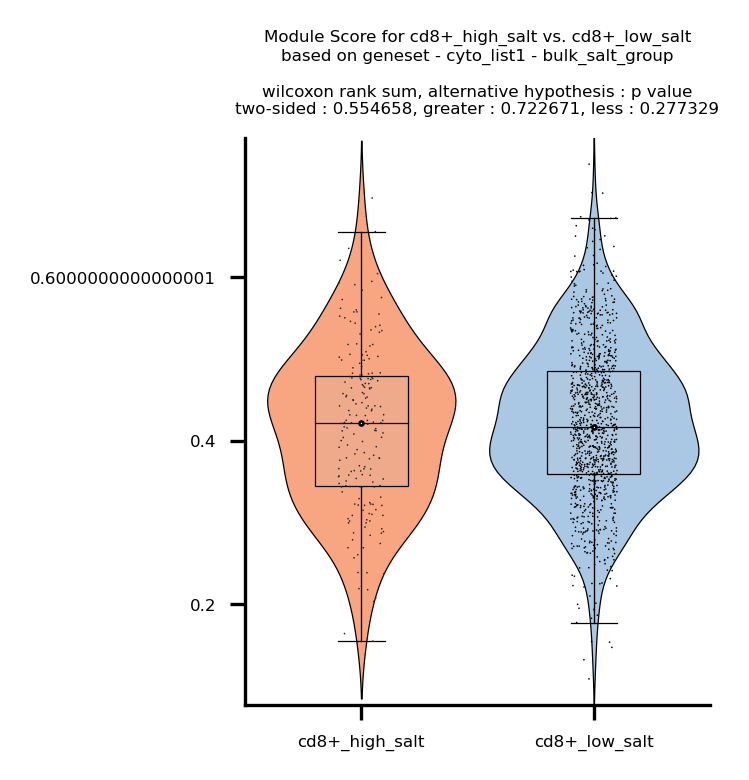

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


--------------------------------------------------------


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Figure size 432x288 with 0 Axes>

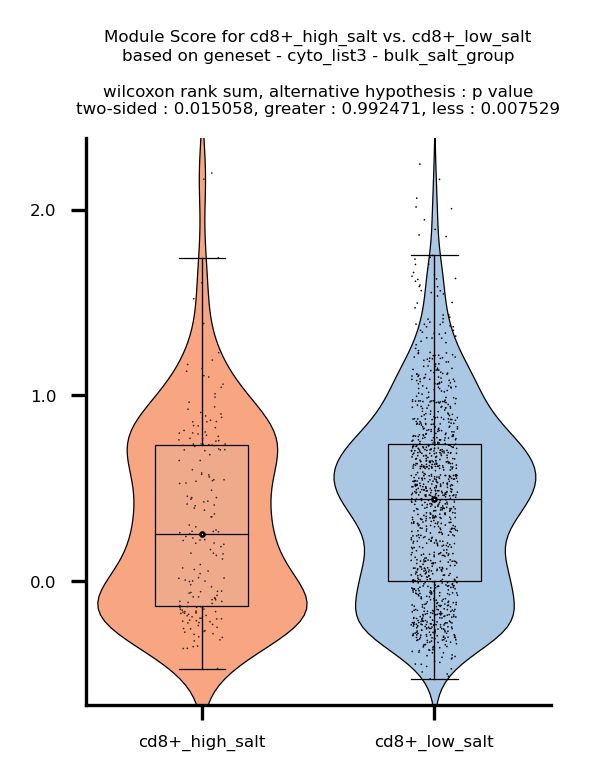

--------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [23]:
genes = {'cyto_list1' : pd.read_csv('./cyto_list1.csv', sep = '\t'),
         'cyto_list3' : pd.read_csv('./cyto_list3.csv', sep = '\t'),
        }

for geneset_name, geneset in genes.items():
    for group in ['bulk_salt_group']:
        utilis.violin_plot(original_adata = adata_cd8,
                colors = ['#ffa37b', '#A7C7E7'],
                group = group, 
                group_conditions = ['cd8+_high_salt', 'cd8+_low_salt'],
                geneset = geneset['genes'],
                geneset_name = f'{geneset_name} - {group}',
                module_score = True)
    print('--------------------------------------------------------')